In [22]:
import numpy as np
def rdnumpy(txtname):
    f = open(txtname)
    line = f.readlines()
    lines = len(line)  # row number
    for l in line:
        le = l.strip('\n').split(',')
        columns = len(le)-1  # col
        #print(le)
        #print(columns)
 
    A = np.zeros((lines, columns+1), dtype=np.single)
    print("read lines:",lines)
    print("read columns:",columns+1)
    A_row = 0
    for lin in line:
        #print(A_row)
        list = lin.strip('\n').split(',')
        A[A_row:] = list[0:columns+1]
        A_row += 1
    return A

In [23]:
#### Train &Test: 3360+1440

# Model

In [24]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Lambda
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [25]:
n_epochs = 3
batch_size_train = 6 #32,或者16-由於數據集比較小
batch_size_test = 1440*3
learning_rate = 0.001 #0.0001
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

# test

In [26]:
TrainDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTrainGf1.txt"))
TrainDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTrainGw0.txt"))
TrainDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTrainGm3.txt"))

read lines: 3360
read columns: 9
read lines: 3360
read columns: 9
read lines: 3360
read columns: 9


In [27]:
i=1        
startRow=i*8;
enRow=(i+1)*8;
TrainDataf1[startRow:enRow,1:9]


tensor([[ 1.0000,  0.1183,  0.0282,  0.7150,  0.0582,  0.3687, -1.2881, 15.0000],
        [ 2.0000,  1.2780,  2.4357,  0.9571,  1.0776,  0.8969,  3.3460, 15.0000],
        [ 3.0000,  1.1799,  3.1711,  0.9647,  0.8765,  0.8870, 21.6785, 15.0000],
        [ 4.0000,  1.1765,  3.3322,  0.9584,  0.9050,  0.8870, 18.8320, 15.0000],
        [ 5.0000,  1.2407,  2.1534,  0.9738,  0.9513,  0.9368,  3.2906, 15.0000],
        [ 6.0000,  1.2150,  1.9671,  0.9528,  0.9086,  0.8969, -4.1514, 15.0000],
        [ 7.0000,  1.2201,  2.6830,  0.9509,  0.9928,  0.8670,  4.6306, 15.0000],
        [ 8.0000,  1.2198,  3.7038,  0.9554,  0.9882,  0.8969, 11.2714, 15.0000]])

In [28]:
class ScottTrainDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TrainDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTrainGf1.txt"))
        TrainDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTrainGw0.txt"))
        TrainDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTrainGm3.txt"))
        #TrainDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTrainGq4.txt"))
        
        self.AllTrainData=torch.cat((TrainDataw0,TrainDataf1,TrainDatam3),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 420*3
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:7]
        
        if index>=0 and index<420:
            nowLabel=1
        elif index>=420 and index<420*2:
            nowLabel=0
        elif index>=420*2 and index<420*3:
            nowLabel=2
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
        return nowData, nowLabel#需要返回數據和標簽

In [29]:
class ScottTestDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        TestDataf1=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTestGf1.txt"))
        TestDataw0=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTestGw0.txt"))
        TestDatam3=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat19\MTestGm3.txt"))
        #TestDataq4=torch.as_tensor(rdnumpy("D:\FYP-HPC\Data_Python\GCN_PAPER_DiffRat_6F_1s\Rat16\MTestGq4.txt"))
        
        self.AllTrainData=torch.cat((TestDataw0,TestDataf1,TestDatam3),0)
        # 定义transform
        self.transform = transform
        self.target_transform = target_transform
 
    def __len__(self):
        '''返回数据集中的样本数'''
        return 180*3
 
    def __getitem__(self, index):#需要第index個的數據
        '''获取数据的方法，会和Dataloader连用'''
        i=index;        
        startRow=i*8;
        enRow=(i+1)*8;
        nowData=self.AllTrainData[startRow:enRow,2:7]
        
        if index>=0 and index<180:
            nowLabel=1
        elif index>=180 and index<180*2:
            nowLabel=0
        elif index>=180*2 and index<180*3:
            nowLabel=2
            
        if self.transform:
            nowData = self.transform(nowData)
        if self.target_transform:
            nowLabel = self.target_transform(nowLabel)
            
        '''
        if nowLabel==0:
            nowLabel = torch.FloatTensor([1, 0])
        else:
            nowLabel = torch.FloatTensor([0, 1])
        '''
            
        return nowData, nowLabel#需要返回數據和標簽

In [30]:
train_loader = torch.utils.data.DataLoader(ScottTrainDataset(),
    batch_size=batch_size_train, shuffle=True)


test_loader = torch.utils.data.DataLoader(ScottTestDataset(),
    batch_size=batch_size_test, shuffle=True)

read lines: 3360
read columns: 9
read lines: 3360
read columns: 9
read lines: 3360
read columns: 9
read lines: 1440
read columns: 9
read lines: 1440
read columns: 9
read lines: 1440
read columns: 9


# Network

In [31]:
#https://zhuanlan.zhihu.com/p/199624393
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(10,20, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(40, 15)
        self.fc2 = nn.Linear(15, 3)
    def forward(self, x):
        ##print(x)##
        #print("begin")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("relu1:")
        #print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("relu2:")
        #print(x.shape)
        x = x.view(-1,40)
        #print("view:")
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print("relu3:")
        #print(x.shape)
        x = F.dropout(x, training=self.training) 
        #print("dropout")
        #print(x.shape)
        x = self.fc2(x)
        #print("fc2")
        #print(x.shape)
        return F.log_softmax(x, dim=-1)
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [32]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

# Train

In [33]:
#for batch_idx, (data, target) in enumerate(train_loader):
        #print(data.shape)
        #print(data)

In [34]:
train_losses = []
train_counter = []

def train(epoch):
  for _ in range(epoch):
      network.train()
      for batch_idx, (data, target) in enumerate(train_loader):
        #if batch_idx>1920 and batch_idx<1920+320: continue
        optimizer.zero_grad()
        data = data.unsqueeze(1)
        #print(data.shape)
        #print(data)
        output = network(data)
        #print(target.shape, target, output)
        #assert 1==0
        #loss = F.binary_cross_entropy_with_logits(output, target)
        ##
        #print("output:")
        #print(output)
        #print("target:")
        #print(target)
        #print(target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        '''
        print(torch.isnan(data).sum(), (target==1).sum()+(target==0).sum())
        assert (target==1).sum()+(target==0).sum()==16
        print(torch.isnan(data).sum(), target.shape, target, output)
        if torch.isnan(output).sum()!=0:
            print(data, target, torch.isnan(data).sum())
            print(data[-5])
        assert torch.isnan(output).sum()==0
        assert torch.isnan(loss).sum()==0
        '''
        if batch_idx % log_interval == 0:
          #print(torch.isnan(data).sum(), target.shape, target, output)
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            _ , batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
          torch.save(network.state_dict(), './model.pth')
          torch.save(optimizer.state_dict(), './optimizer.pth')
          #print(network.state_dict())
    
train(50)

Train Epoch: 0 [0/1260 (0%)]	Loss: 1.108506
Train Epoch: 0 [60/1260 (5%)]	Loss: 1.140456
Train Epoch: 0 [120/1260 (10%)]	Loss: 1.083279
Train Epoch: 0 [180/1260 (14%)]	Loss: 1.070431
Train Epoch: 0 [240/1260 (19%)]	Loss: 1.030589
Train Epoch: 0 [300/1260 (24%)]	Loss: 0.987474
Train Epoch: 0 [360/1260 (29%)]	Loss: 1.045798
Train Epoch: 0 [420/1260 (33%)]	Loss: 0.982399
Train Epoch: 0 [480/1260 (38%)]	Loss: 0.989617
Train Epoch: 0 [540/1260 (43%)]	Loss: 1.048126
Train Epoch: 0 [600/1260 (48%)]	Loss: 0.907860
Train Epoch: 0 [660/1260 (52%)]	Loss: 0.755922
Train Epoch: 0 [720/1260 (57%)]	Loss: 0.786310
Train Epoch: 0 [780/1260 (62%)]	Loss: 0.779890
Train Epoch: 0 [840/1260 (67%)]	Loss: 0.694518
Train Epoch: 0 [900/1260 (71%)]	Loss: 0.621619
Train Epoch: 0 [960/1260 (76%)]	Loss: 0.944931
Train Epoch: 0 [1020/1260 (81%)]	Loss: 0.385451
Train Epoch: 0 [1080/1260 (86%)]	Loss: 0.420220
Train Epoch: 0 [1140/1260 (90%)]	Loss: 0.636430
Train Epoch: 0 [1200/1260 (95%)]	Loss: 0.602144
Train Epoch: 1

Train Epoch: 8 [600/1260 (48%)]	Loss: 0.002773
Train Epoch: 8 [660/1260 (52%)]	Loss: 0.226434
Train Epoch: 8 [720/1260 (57%)]	Loss: 0.002663
Train Epoch: 8 [780/1260 (62%)]	Loss: 0.008624
Train Epoch: 8 [840/1260 (67%)]	Loss: 0.084532
Train Epoch: 8 [900/1260 (71%)]	Loss: 0.028450
Train Epoch: 8 [960/1260 (76%)]	Loss: 0.077726
Train Epoch: 8 [1020/1260 (81%)]	Loss: 0.695272
Train Epoch: 8 [1080/1260 (86%)]	Loss: 0.017768
Train Epoch: 8 [1140/1260 (90%)]	Loss: 0.002724
Train Epoch: 8 [1200/1260 (95%)]	Loss: 0.015567
Train Epoch: 9 [0/1260 (0%)]	Loss: 0.168633
Train Epoch: 9 [60/1260 (5%)]	Loss: 0.001261
Train Epoch: 9 [120/1260 (10%)]	Loss: 0.014396
Train Epoch: 9 [180/1260 (14%)]	Loss: 0.015210
Train Epoch: 9 [240/1260 (19%)]	Loss: 0.215256
Train Epoch: 9 [300/1260 (24%)]	Loss: 0.005290
Train Epoch: 9 [360/1260 (29%)]	Loss: 0.010459
Train Epoch: 9 [420/1260 (33%)]	Loss: 0.030540
Train Epoch: 9 [480/1260 (38%)]	Loss: 0.002684
Train Epoch: 9 [540/1260 (43%)]	Loss: 0.002572
Train Epoch: 9

Train Epoch: 16 [1140/1260 (90%)]	Loss: 0.001123
Train Epoch: 16 [1200/1260 (95%)]	Loss: 0.008282
Train Epoch: 17 [0/1260 (0%)]	Loss: 0.005810
Train Epoch: 17 [60/1260 (5%)]	Loss: 0.015555
Train Epoch: 17 [120/1260 (10%)]	Loss: 0.022303
Train Epoch: 17 [180/1260 (14%)]	Loss: 0.099529
Train Epoch: 17 [240/1260 (19%)]	Loss: 0.002189
Train Epoch: 17 [300/1260 (24%)]	Loss: 0.002684
Train Epoch: 17 [360/1260 (29%)]	Loss: 0.018320
Train Epoch: 17 [420/1260 (33%)]	Loss: 0.017542
Train Epoch: 17 [480/1260 (38%)]	Loss: 0.007829
Train Epoch: 17 [540/1260 (43%)]	Loss: 0.164458
Train Epoch: 17 [600/1260 (48%)]	Loss: 0.009069
Train Epoch: 17 [660/1260 (52%)]	Loss: 0.083256
Train Epoch: 17 [720/1260 (57%)]	Loss: 0.000657
Train Epoch: 17 [780/1260 (62%)]	Loss: 0.000452
Train Epoch: 17 [840/1260 (67%)]	Loss: 0.000588
Train Epoch: 17 [900/1260 (71%)]	Loss: 0.001066
Train Epoch: 17 [960/1260 (76%)]	Loss: 0.019292
Train Epoch: 17 [1020/1260 (81%)]	Loss: 0.016072
Train Epoch: 17 [1080/1260 (86%)]	Loss: 0.

Train Epoch: 25 [420/1260 (33%)]	Loss: 0.018432
Train Epoch: 25 [480/1260 (38%)]	Loss: 0.001961
Train Epoch: 25 [540/1260 (43%)]	Loss: 0.015875
Train Epoch: 25 [600/1260 (48%)]	Loss: 0.523281
Train Epoch: 25 [660/1260 (52%)]	Loss: 0.015575
Train Epoch: 25 [720/1260 (57%)]	Loss: 0.008135
Train Epoch: 25 [780/1260 (62%)]	Loss: 0.017571
Train Epoch: 25 [840/1260 (67%)]	Loss: 0.020412
Train Epoch: 25 [900/1260 (71%)]	Loss: 0.037566
Train Epoch: 25 [960/1260 (76%)]	Loss: 0.008384
Train Epoch: 25 [1020/1260 (81%)]	Loss: 0.000570
Train Epoch: 25 [1080/1260 (86%)]	Loss: 0.000002
Train Epoch: 25 [1140/1260 (90%)]	Loss: 0.000573
Train Epoch: 25 [1200/1260 (95%)]	Loss: 0.028581
Train Epoch: 26 [0/1260 (0%)]	Loss: 0.004926
Train Epoch: 26 [60/1260 (5%)]	Loss: 0.495976
Train Epoch: 26 [120/1260 (10%)]	Loss: 0.004111
Train Epoch: 26 [180/1260 (14%)]	Loss: 0.002834
Train Epoch: 26 [240/1260 (19%)]	Loss: 0.000231
Train Epoch: 26 [300/1260 (24%)]	Loss: 0.000586
Train Epoch: 26 [360/1260 (29%)]	Loss: 0.

Train Epoch: 33 [960/1260 (76%)]	Loss: 0.021960
Train Epoch: 33 [1020/1260 (81%)]	Loss: 0.000702
Train Epoch: 33 [1080/1260 (86%)]	Loss: 0.006748
Train Epoch: 33 [1140/1260 (90%)]	Loss: 0.000776
Train Epoch: 33 [1200/1260 (95%)]	Loss: 0.164989
Train Epoch: 34 [0/1260 (0%)]	Loss: 0.001459
Train Epoch: 34 [60/1260 (5%)]	Loss: 0.018144
Train Epoch: 34 [120/1260 (10%)]	Loss: 0.026767
Train Epoch: 34 [180/1260 (14%)]	Loss: 0.016898
Train Epoch: 34 [240/1260 (19%)]	Loss: 0.141355
Train Epoch: 34 [300/1260 (24%)]	Loss: 0.000653
Train Epoch: 34 [360/1260 (29%)]	Loss: 0.055640
Train Epoch: 34 [420/1260 (33%)]	Loss: 0.032232
Train Epoch: 34 [480/1260 (38%)]	Loss: 0.000015
Train Epoch: 34 [540/1260 (43%)]	Loss: 0.001175
Train Epoch: 34 [600/1260 (48%)]	Loss: 0.044016
Train Epoch: 34 [660/1260 (52%)]	Loss: 0.732068
Train Epoch: 34 [720/1260 (57%)]	Loss: 0.005386
Train Epoch: 34 [780/1260 (62%)]	Loss: 0.003508
Train Epoch: 34 [840/1260 (67%)]	Loss: 0.427774
Train Epoch: 34 [900/1260 (71%)]	Loss: 0.

Train Epoch: 42 [360/1260 (29%)]	Loss: 0.008025
Train Epoch: 42 [420/1260 (33%)]	Loss: 0.052948
Train Epoch: 42 [480/1260 (38%)]	Loss: 0.000852
Train Epoch: 42 [540/1260 (43%)]	Loss: 0.000000
Train Epoch: 42 [600/1260 (48%)]	Loss: 0.001505
Train Epoch: 42 [660/1260 (52%)]	Loss: 0.018867
Train Epoch: 42 [720/1260 (57%)]	Loss: 0.000557
Train Epoch: 42 [780/1260 (62%)]	Loss: 0.000037
Train Epoch: 42 [840/1260 (67%)]	Loss: 0.007480
Train Epoch: 42 [900/1260 (71%)]	Loss: 0.000954
Train Epoch: 42 [960/1260 (76%)]	Loss: 0.017264
Train Epoch: 42 [1020/1260 (81%)]	Loss: 0.002338
Train Epoch: 42 [1080/1260 (86%)]	Loss: 0.020567
Train Epoch: 42 [1140/1260 (90%)]	Loss: 0.000064
Train Epoch: 42 [1200/1260 (95%)]	Loss: 0.011202
Train Epoch: 43 [0/1260 (0%)]	Loss: 0.023502
Train Epoch: 43 [60/1260 (5%)]	Loss: 0.034822
Train Epoch: 43 [120/1260 (10%)]	Loss: 0.002998
Train Epoch: 43 [180/1260 (14%)]	Loss: 0.009525
Train Epoch: 43 [240/1260 (19%)]	Loss: 0.014419
Train Epoch: 43 [300/1260 (24%)]	Loss: 0.

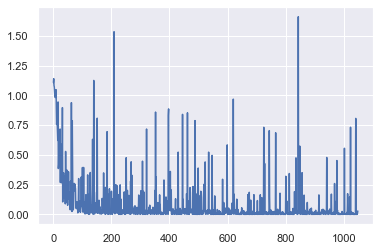

In [35]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

plt.plot(list(range(len(train_losses))), train_losses)
plt.show()

In [36]:
'''
for p in network.parameters():
    print(p)
    break
tmp = torch.load('./model.pth')
network.load_state_dict(tmp)
for p in network.parameters():
    print(p)
    break
'''

"\nfor p in network.parameters():\n    print(p)\n    break\ntmp = torch.load('./model.pth')\nnetwork.load_state_dict(tmp)\nfor p in network.parameters():\n    print(p)\n    break\n"

In [37]:
import scipy.io as io
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.unsqueeze(1)
      #print("data:")
      #print(data.shape)
      output = network(data)
      #print("output:")
      #print(output.shape)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)###
      result1 = np.array(pred)
      np.savetxt('pred.txt',result1)
      result2 = np.array(target)
      np.savetxt('target.txt',result2)
      
      #Save done
      correct += pred.eq(target.data.view_as(pred)).sum()
      
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
    
test()


Test set: Avg. loss: 0.0067, Accuracy: 539/540 (99.81%)



C:\Users\PCI\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [38]:
'''
import scipy.io as io
result1 = np.array(result1)
np.savetxt('npresult1.txt',result1)
'''

"\nimport scipy.io as io\nresult1 = np.array(result1)\nnp.savetxt('npresult1.txt',result1)\n"

In [39]:
'''
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()
'''

"\nfor epoch in range(1, n_epochs + 1):\n  train(epoch)\n  test()\nimport matplotlib.pyplot as plt\nfig = plt.figure()\nplt.plot(train_counter, train_losses, color='blue')\nplt.scatter(test_counter, test_losses, color='red')\nplt.legend(['Train Loss', 'Test Loss'], loc='upper right')\nplt.xlabel('number of training examples seen')\nplt.ylabel('negative log likelihood loss')\nplt.show()\n"

# confusion matrix

In [40]:
  import scipy.io as io
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.unsqueeze(1)
      #print("data:")
      #print(data.shape)
      output = network(data)
      #print("output:")
      #print(output.shape)
      
      test_loss += F.nll_loss(output, target, size_average=False).item()
      #print(output)
      pred = output.data.max(1, keepdim=True)[1]
      #print(pred)###
      result1 = np.array(pred)
      #np.savetxt('pred.txt',result1)
      result2 = np.array(target)
      #np.savetxt('target.txt',result2)
      
      #Save done
      correct += pred.eq(target.data.view_as(pred)).sum()
      
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: 0.0067, Accuracy: 539/540 (100%)



In [41]:
from sklearn.metrics import f1_score
 
y_true = target
y_pred = pred
 
print(f1_score(y_true, y_pred, average='weighted'))# unbalance F1
print(f1_score(y_true, y_pred, average='macro'))
print()
print(f1_score(y_true, y_pred, average=None))
print("Acute       Normal      Chronic")

0.9981481338590575
0.9981481338590575

[0.99722992 0.99721448 1.        ]
Acute       Normal      Chronic


[[100.     0.     0.  ]
 [  0.56  99.44   0.  ]
 [  0.     0.   100.  ]]


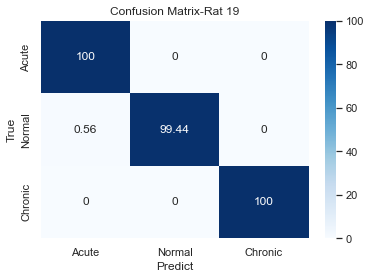

In [42]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

sns.set()
f,ax = plt.subplots()
y_true =(target)
y_pred = (pred)
C2 = confusion_matrix(y_true,y_pred,labels=[0,1,2])

fm=C2.sum(axis=1)
C3=C2/fm*100
C3=np.around(C3,decimals=2)

print(C3)
a=sns.heatmap(C3,annot=True,ax=ax, cmap = 'Blues', fmt='g') #画热力图  , cbar = None

ax.set_title('Confusion Matrix-Rat 19') #标题
ax.set_xlabel('Predict') #x 轴
ax.set_ylabel('True') #y 轴


#Normal, Acute, Chronic, Pre-seizure
a.set_xticklabels(['Acute','Normal','Chronic'])
a.set_yticklabels(['Acute','Normal','Chronic'])


fig = a.get_figure()
fig.savefig("6F_3C.png", dpi=1080)